# Robotic Systems I (ECE-DK808)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 4

In this lab, we are going to implement trajectory generation for $SO(3)$ and $SE(3)$ spaces. In particular, we will implement cubic splines.

First, let's get some basic math.

In [1]:
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting

np.set_printoptions(precision=2, suppress=True)

# Rotations around principal axes
def RotX(theta):
    ct = np.cos(theta)
    st = np.sin(theta)
    R = np.eye(3, 3)
    R[1, 1] = ct
    R[1, 2] = -st
    R[2, 1] = st
    R[2, 2] = ct
    return R

def RotY(theta):
    ct = np.cos(theta)
    st = np.sin(theta)
    R = np.eye(3, 3)
    R[0, 0] = ct
    R[0, 2] = st
    R[2, 0] = -st
    R[2, 2] = ct
    return R

def RotZ(theta):
    ct = np.cos(theta)
    st = np.sin(theta)
    R = np.eye(3, 3)
    R[0, 0] = ct
    R[0, 1] = -st
    R[1, 0] = st
    R[1, 1] = ct
    return R

In [2]:
# hat, unhat operations
def hat(vec):
    v = vec.reshape((3,))
    return np.array([
        [0., -v[2], v[1]],
        [v[2], 0., -v[0]],
        [-v[1], v[0], 0.]
    ])

def unhat(mat):
    return np.array([[mat[2, 1], mat[0, 2], mat[1, 0]]]).T

# exp for SO(3)
def exp_rotation(p):
    phi = p.reshape((3, 1))
    theta = np.linalg.norm(phi)
    if theta < 1e-12:
        return np.eye(3, 3)
    a = phi / theta
    return np.eye(3) * np.cos(theta) + (1. - np.cos(theta)) * a @ a.T + np.sin(theta) * hat(a)

# log for SO(3)
def log_rotation(R):
    theta = np.arccos(max(-1., min(1., (np.trace(R) - 1.) / 2.)))

    if np.isclose(theta, 0.):
        return np.zeros((3, 1))
    elif np.isclose(theta, np.pi):
        r00 = R[0, 0]
        r11 = R[1, 1]
        r22 = R[2, 2]

        r02 = R[0, 2]
        r12 = R[1, 2]

        r01 = R[0, 1]
        r21 = R[2, 1]

        r10 = R[1, 0]
        r20 = R[2, 0]

        if not np.isclose(r22, -1.):
            multiplier = theta / np.sqrt(2. * (1. + r22))
            return multiplier * np.array([[r02, r12, 1. + r22]]).T
        elif not np.isclose(r11, -1.):
            multiplier = theta / np.sqrt(2. * (1. + r11))
            return multiplier * np.array([[r01, 1. + r11, r21]]).T
        elif not np.isclose(r00, -1.):
            multiplier = theta / np.sqrt(2. * (1. + r00))
            return multiplier * np.array([[1. + r00, r10, r20]]).T
        else:
            print("ERROR: This should never happen!")
            exit(1)

    mat = R - R.T
    r = unhat(mat)

    return theta / (2. * np.sin(theta)) * r

Now let's implement the following functions:

$\boldsymbol{J}_l(\boldsymbol{\phi}) = \boldsymbol{I} + \frac{1-\cos\phi}{\phi^2}\boldsymbol{\phi}^\land + \frac{\phi-\sin\phi}{\phi^3}\boldsymbol{\phi}^\land\boldsymbol{\phi}^\land$

$\boldsymbol{J}_l^{-1}(\boldsymbol{\phi}) = \boldsymbol{I} - \frac{1}{2}\boldsymbol{\phi}^\land + (\frac{1}{\phi^2}-\frac{1+\cos\phi}{2\phi\sin\phi})\boldsymbol{\phi}^\land\boldsymbol{\phi}^\land$

We have $\boldsymbol{\phi} = \phi\boldsymbol{r}$.

In [3]:
def J_l(q, epsilon = 1e-8):
    ### TO-DO: Implement the $J_l$ function. You should return a numpy array with dimensions 3x3.
    ### ANSWER: Insert code here
    phi = np.linalg.norm(q)
    
    if(phi < epsilon): return np.eye(3)
    else: return np.eye(3) + ((1 - np.cos(phi)) / (phi ** 2)) * hat(q) + ((phi - np.sin(phi)) / (phi ** 3)) * (hat(q) @ hat(q))
    ### END of ANSWER

def J_l_inv(q, epsilon = 1e-8):
    ### TO-DO: Implement the $J_l^{-1}$ function. You should return a numpy array with dimensions 3x3.
    ### ANSWER: Insert code here
    phi = np.linalg.norm(q)
    
    if(phi < epsilon): return np.eye(3)
    else: return np.eye(3) - 0.5 * hat(q) + ((1 / (phi ** 2)) - ((1 + np.cos(phi)) / (2 * phi * np.sin(phi)))) * (hat(q) @ hat(q))
    ### END of ANSWER

In [4]:
assert(np.isclose(J_l(np.zeros((3, 1))), np.eye(3)).all())
assert(np.isclose(J_l_inv(np.zeros((3, 1))), np.eye(3)).all())

phi = np.array([[1., 0., 0.]]).T
J_l_phi = np.array([[1., 0., 0.], [0., 0.84, -0.46], [0., 0.46, 0.84]])
J_l_inv_phi = np.array([[1., 0., 0.], [0., 0.92, 0.5], [0., -0.5, 0.92]])
assert(np.isclose(J_l(phi), J_l_phi, rtol=1e-2).all())
assert(np.isclose(J_l_inv(phi), J_l_inv_phi, rtol=1e-2).all())

phi = np.array([[0., 1., 0.]]).T
J_l_phi = np.array([[0.84, 0., 0.46], [0., 1., 0.], [-0.46, 0., 0.84]])
J_l_inv_phi = np.array([[0.92, 0., -0.5], [0., 1., 0.], [0.5, 0., 0.92]])
assert(np.isclose(J_l(phi), J_l_phi, rtol=1e-2).all())
assert(np.isclose(J_l_inv(phi), J_l_inv_phi, rtol=1e-2).all())


Now, let's implement the $\exp$ and $\log$ operations for $SE(3)$:

$\boldsymbol{\xi} = \begin{bmatrix}\boldsymbol{\phi}\\\boldsymbol{\rho}\end{bmatrix}\in\mathbb{R}^6$

$\exp(\boldsymbol{\xi}^\land) = \boldsymbol{T} = \begin{bmatrix}\exp(\boldsymbol{\phi}^\land) & \boldsymbol{J}_l(\boldsymbol{\phi})\boldsymbol{\rho}\\\boldsymbol{0} & 1\end{bmatrix}$

$\log(\boldsymbol{T})^\lor = \boldsymbol{\xi} = \begin{bmatrix}\log(\boldsymbol{R})^\lor\\\boldsymbol{J}_l^{-1}(\boldsymbol{\phi})\boldsymbol{t}\end{bmatrix}$

where $\boldsymbol{\xi}^\land = \begin{bmatrix}\boldsymbol{\phi}^\land & \boldsymbol{\rho}\\\boldsymbol{0} & 0\end{bmatrix}$

In [5]:
def skew_pose(xi):
    ### TO-DO: Implement the skew operator for SE(3): ξ^. You should return a numpy array with dimensions 4x4.
    ### ANSWER: Insert code here
    phi = np.array([xi[0], xi[1], xi[2]])
    rho = np.array([xi[3], xi[4], xi[5]])
    
    arr = np.block([[      hat(phi), rho],
                    [np.zeros((3,)),   0]])
    return arr
    ### END of ANSWER

def unskew_pose(T):
    ### TO-DO: Implement the un-skew operator for SE(3). You should return a numpy array with dimensions 6x1.
    ### ANSWER: Insert code here
    phi = unhat(T[:3, :3])
    rho = np.array([T[:3, 3]]).reshape(3,1)
    vec = np.block([[phi], [rho]])
    
    return vec
    ### END of ANSWER

def exp_pose(xi):
    ### TO-DO: Implement the exp operator for SE(3). You should return a numpy array with dimensions 4x4.
    ### ANSWER: Insert code here
    phi = np.array([xi[0], xi[1], xi[2]])
    rho = np.array([xi[3], xi[4], xi[5]])
    
    arr = np.block([[exp_rotation(phi), J_l(phi) @ rho],
                    [   np.zeros((3,)),              1]])
    
    return arr
    ### END of ANSWER

def log_pose(T):
    ### TO-DO: Implement the log operator for SE(3). You should return a numpy array with dimensions 6x1.
    ### ANSWER: Insert code here
    R = T[:3, :3]
    t = np.array([T[:3, 3]]).reshape(3,1)
    phi = log_rotation(R)

    vec = np.block([[phi], [J_l_inv(phi) @ t]])
    
    return vec
    ### END of ANSWER

In [6]:
from scipy.linalg import expm
from scipy.linalg import logm

xi = np.array([[1., -3., 0.2, 2., 3., 1.]]).T
T = np.eye(4)
T[:3, :3] = RotX(np.pi / 3.)
T[:3, 3:] = np.array([[3., 2., -1.]]).T

assert(np.isclose(exp_pose(xi), expm(skew_pose(xi))).all())
assert(np.isclose(unskew_pose(logm(T)), log_pose(T)).all())


Now, it's time to generate some trajectories in $SO(3)$. In particular, we will create the following 3 functions:

1. $\text{cubic\_coeffs\_so3}(\boldsymbol{R}_{\text{start}}, \boldsymbol{\omega}_{\text{start}}, \boldsymbol{R}_{\text{target}}, \boldsymbol{\omega}_{\text{target}}, T)$, a function that calculates the cubic spline coefficients for a trajectory that starts at $\boldsymbol{R}_{\text{start}}$ with an angular velocity $\boldsymbol{\omega}_{\text{start}}$ and ends at $\boldsymbol{R}_{\text{target}}$ with an angular velocity $\boldsymbol{\omega}_{\text{target}}$ at time $t=T$. The function should return four 3 dimensional vectors which correspond to the coefficients for the spline: $\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3$.
2. $\text{pos\_spline\_so3}(\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3, t)$, a function that takes as input the coefficients of the cubic spline and computes the rotation at time $t$: $\boldsymbol{R}(t)$
3. $\text{vel\_spline\_so3}(\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3, t)$, a function that takes as input the coefficients of the cubic spline and computes the angular velocity at time $t$: $\boldsymbol{\omega}(t)$


In [7]:
def cubic_coeffs_so3(Rs, ws, Rg, wg, T):
    ### TO-DO: Implement the cubic_coeffs_so3() function defined above.
    ### ANSWER: Insert code here
    phi_g = log_rotation(Rg)
    phi_s = log_rotation(Rs)
    
    c0 = phi_s
    c1 = ws
    c2 = (3 * phi_g) / (T ** 2) - (3 * phi_s) / (T ** 2) - (2 * ws) / T - wg / T
    c3 = (-2 * phi_g) / (T ** 3) + (2 * phi_s) / (T ** 3) + ws / (T ** 2) + wg / (T ** 2)

    return c0, c1, c2, c3
    ### END of ANSWER

def pos_spline_so3(c0, c1, c2, c3, t):
    ### TO-DO: Implement the pos_spline_so3() function defined above.
    ### ANSWER: Insert code here
    return exp_rotation(c3 * (t ** 3) + c2 * (t ** 2) + c1 * t + c0)
    ### END of ANSWER

def vel_spline_so3(c0, c1, c2, c3, t):
    ### TO-DO: Implement the vel_spline_so3() function defined above.
    ### ANSWER: Insert code here
    R = pos_spline_so3(c0, c1, c2, c3, t)
    R_dot = (3 * hat(c3) * (t ** 2) + 2 * hat(c2) * t + hat(c1)) @ R
    w = R @ R_dot
    
    return w
    ### END of ANSWER

In [8]:
R1 = RotX(np.pi)
w1 = np.zeros((3, 1))

R2 = RotY(np.pi/2.)
w2 = np.zeros((3, 1))

T = 1.

c0, c1, c2, c3 = cubic_coeffs_so3(R1, w1, R2, w2, T)

assert(np.isclose(R1, pos_spline_so3(c0, c1, c2, c3, 0.)).all())
assert(np.isclose(R2, pos_spline_so3(c0, c1, c2, c3, 1.)).all())

assert(np.isclose(w1, vel_spline_so3(c0, c1, c2, c3, 0.)).all())
assert(np.isclose(w2, vel_spline_so3(c0, c1, c2, c3, 1.)).all())

assert(not np.isclose(pos_spline_so3(c0, c1, c2, c3, 0.5), R1 @ exp_rotation(0.5 * log_rotation(R1.T @ R2))).all())


Let's try it!

In [9]:
Rs = RotX(np.pi/2.)
ws = np.zeros((3, 1))

Rg = RotX(np.pi/2.) @ RotZ(np.pi/3.) @ RotX(3.*np.pi/4.)
wg = np.zeros((3, 1))

T = 3.

c0, c1, c2, c3 = cubic_coeffs_so3(Rs, ws, Rg, wg, T)

In [10]:
# Let's see what we have
ts = np.linspace(0., T, 20)

poses = []
for t in ts:
    poses.append(pos_spline_so3(c0, c1, c2, c3, t))

In [11]:
# Plot the frame
def plot_frame(ax, R, origin=np.zeros((3,1)), alpha=1., length=0.5):
    xaxis = R @ np.array([[1., 0., 0.]]).T
    yaxis = R @ np.array([[0., 1., 0.]]).T
    zaxis = R @ np.array([[0., 0., 1.]]).T

    ax.quiver(*origin, *xaxis, color='r', length=length, alpha=alpha)
    ax.quiver(*origin, *yaxis, color='g', length=length, alpha=alpha)
    ax.quiver(*origin, *zaxis, color='b', length=length, alpha=alpha)

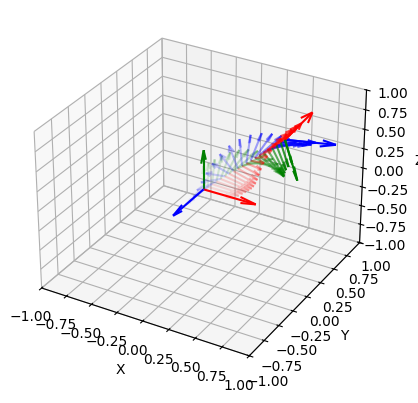

In [12]:
# Plot the original and transformed trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot coordinate frames for the SO(3) trajectory
start_alpha = 0.1

final_alpha = 1.
t_final = np.ones((3, 1)) * 0.5 # this is artificially adding translation so that the visualization is clear
for k in range(len(poses)):
    R = poses[k]
    alpha = start_alpha * np.power(final_alpha / start_alpha, float(k)  / float(len(poses)))
    t = (k / float(len(poses)-1.)) * t_final
    plot_frame(ax, R, t, alpha=alpha, length=0.3)

plot_frame(ax, poses[0]) # start frame
plot_frame(ax, poses[-1], t_final) # target frame

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.axes.set_xlim3d(left=-1., right=1.) 
ax.axes.set_ylim3d(bottom=-1., top=1.) 
ax.axes.set_zlim3d(bottom=-1., top=1.) 

plt.show()

Now it's time to do full poses! Let's create the following functions:

1. $\text{cubic\_coeffs\_se3}(\boldsymbol{T}_{\text{start}}, \mathcal{V}_{\text{start}}, \boldsymbol{T}_{\text{target}}, \mathcal{V}_{\text{target}}, T)$, a function that calculates the cubic spline coefficients for a trajectory that starts at $\boldsymbol{T}_{\text{start}}$ with a twist $\mathcal{V}_{\text{start}}$ and ends at $\boldsymbol{T}_{\text{target}}$ with a twist $\mathcal{V}_{\text{target}}$ at time $t=T$. The function should return four 6 dimensional vectors which correspond to the coefficients for the spline: $\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3$.
2. $\text{pos\_spline\_se3}(\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3, t)$, a function that takes as input the coefficients of the cubic spline and computes the transformation matrix at time $t$: $\boldsymbol{T}(t)$
3. $\text{vel\_spline\_se3}(\boldsymbol{c}_0, \boldsymbol{c}_1, \boldsymbol{c}_2, \boldsymbol{c}_3, t)$, a function that takes as input the coefficients of the cubic spline and computes the twist at time $t$: $\mathcal{V}(t)$


In [ ]:
def cubic_coeffs_se3(Ts, Vs, Tg, Vg, T):
    ### TO-DO: Implement the cubic_coeffs_se3() function defined above.
    ### ANSWER: Insert code here
    tau_s = log_pose(Ts)
    tau_g = log_pose(Tg)
    
    c0 = tau_s
    c1 = Vs
    c2 = (3 * tau_g) / (T ** 2) - (3 * tau_s) / (T ** 2) - (2 * Vs) / T - Vg / T
    c3 = (-2 * tau_g) / (T ** 3) + (2 * tau_s) / (T ** 3) + Vs / (T ** 2) + Vg / (T ** 2)

    return c0, c1, c2, c3
    ### END of ANSWER

def pos_spline_se3(c0, c1, c2, c3, t):
    ### TO-DO: Implement the pos_spline_se3() function defined above.
    ### ANSWER: Insert code here
    return exp_pose(c3 * (t ** 3) + c2 * (t ** 2) + c1 * t + c0)
    ### END of ANSWER

def vel_spline_se3(c0, c1, c2, c3, t):
    ### TO-DO: Implement the vel_spline_se3() function defined above.
    ### ANSWER: Insert code here
    T = pos_spline_se3(c0, c1, c2, c3, t)    
    T_dot = (3 * skew_pose(c3) * (t ** 2) + 2 * skew_pose(c2) * t + skew_pose(c1)) @ T
    V = unskew_pose(np.linalg.inv(T) @ T_dot)
    
    return V
    ### END of ANSWER

In [ ]:
Rs = RotZ(np.pi/2.)
ts = np.ones((3, 1))
Ts = np.block([[Rs, ts], [0., 0., 0., 1.]])
Vs = np.zeros((6, 1))

Rg = RotX(np.pi/3.)
tg = np.ones((3, 1)) * 0.5
Tg = np.block([[Rg, tg], [0., 0., 0., 1.]])
Vg = np.zeros((6, 1))

T = 1.

c0, c1, c2, c3 = cubic_coeffs_se3(Ts, Vs, Tg, Vg, T)

assert(np.isclose(Ts, pos_spline_se3(c0, c1, c2, c3, 0.)).all())
assert(np.isclose(Tg, pos_spline_se3(c0, c1, c2, c3, 1.)).all())

assert(np.isclose(Vs, vel_spline_se3(c0, c1, c2, c3, 0.)).all())
assert(np.isclose(Vg, vel_spline_se3(c0, c1, c2, c3, 1.)).all())

assert(not np.isclose(pos_spline_se3(c0, c1, c2, c3, 0.5), Ts @ exp_pose(0.5 * log_pose(np.linalg.inv(Ts) @ Tg))).all())


In [ ]:
Rs = RotX(np.pi/2.)
ts = np.zeros((3, 1))
Ts = np.block([[Rs, ts], [0., 0., 0., 1.]])
Vs = np.zeros((6, 1))

Rg = RotX(np.pi/2.) @ RotZ(np.pi/3.) @ RotX(3.*np.pi/4.)
tg = np.ones((3, 1)) * 0.5
Tg = np.block([[Rg, tg], [0., 0., 0., 1.]])
Vg = np.zeros((6, 1))

T = 3.

c0, c1, c2, c3 = cubic_coeffs_se3(Ts, Vs, Tg, Vg, T)

In [ ]:
# Let's see what we have
ts = np.linspace(0., T, 20)

poses = []
for t in ts:
    poses.append(pos_spline_se3(c0, c1, c2, c3, t))

In [ ]:
# Plot the original and transformed trajectories
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot coordinate frames for the SO(3) trajectory
start_alpha = 0.1
final_alpha = 1.
for k in range(len(poses)):
    T = poses[k]
    R = T[:3, :3]
    t = T[:3, 3:]
    alpha = start_alpha * np.power(final_alpha / start_alpha, float(k)  / float(len(poses)))
    plot_frame(ax, R, t, alpha=alpha, length=0.3)

plot_frame(ax, Ts[:3, :3], Ts[:3, 3:]) # start frame
plot_frame(ax, Tg[:3, :3], Tg[:3, 3:]) # target frame

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.axes.set_xlim3d(left=-1., right=1.) 
ax.axes.set_ylim3d(bottom=-1., top=1.) 
ax.axes.set_zlim3d(bottom=-1., top=1.) 

plt.show()